In [141]:
# Import Libraries
import pandas as pd
import xlsxwriter
import matplotlib.pyplot as plt
import numpy as np

# Importing statistics libraries
import statsmodels.api as sm

#show plot in notebook
%matplotlib inline 

# Loading and Cleaning the Data

In [142]:
def load_SalesData(dataframe, sheetname):
    '''This function loads an excel dataframe in a specified sheet containing information on 
    Sales Amounts and Dates of Order. It also renames the columns, replaces empty values in the 
    exchange rate column with 1, and creates a new column of Sales_in_CAD'''
    #Loading the main dataset from excel into python, specified taking data from the 'Sales' sheet
    data = pd.read_excel(dataframe, sheetname)
    # Renaming the columns 
    data.columns = [['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 
                        'Year_of_First_Order', 'New_or_Returning']]
    # Replacing the empty values in the Exchange Rate column with 1 and setting the index to Date_of_Order
    Sales_df= data[['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 
                        'Year_of_First_Order', 'New_or_Returning']].replace([None], [1]).set_index('Date_of_Order')
    # Creating a new column in the data set, which puts all sales amounts in Canadian dollars. 
    Sales_df['Sales_in_CAD'] = Sales_df['Exchange_Rate'] * Sales_df['Total_Sales']
    
    #Returning the cleaned table
    return Sales_df
    
def load_AdsData (dataframe, sheetname):
    '''This fucntion loads an excel dataframe in a specified sheet containing information on 
    Cost of Ads per month. It also renames the two columns.'''
    #Loading another dataset from excel into python from a different sheet, and making the Date column the index.
    Ads_df = pd.read_excel(dataframe, sheetname).set_index('Date')
    # Renaming the columns
    Ads_df.columns = [['Ad_Cost']]
    
    return Ads_df

In [143]:
# Testing the load data functions to see what the output table looks like
Salesdata = load_SalesData ('../data/SalesDataA.xlsm', sheetname = 'Sales')
Adsdata = load_AdsData ('../data/SalesDataA.xlsm', sheetname = 'Ads')
Adsdata.head()

,Ad_Cost
Date,
2013-08-01,947.94
2013-09-01,936.06
2013-10-01,935.72
2013-11-01,930.47
2013-12-01,948.00


# Merging the two Dataframes, and downsampling to Month. 

In [144]:
def merging_data(dataframe1, dataframe2):
    '''This function merges the two dataframes that were previously 
    created with the two loading data functions. It resamples the Date column to Month and then 
    merges the two dataframes by the Date column. The function returns the merged dataframe.'''
    
    # The Exchange_df has to be downsampled first:
    # All rows with dates equal to and under 2013-07-31 will be deleted.
    Change_New = dataframe1[dataframe1.index > '2013-07-31'].reset_index()
    # Deleting all rows of sales from returning customers, to obtain Sales only from new customers. 
    Change1_New = Change_New.groupby(['New_or_Returning']).get_group('New')
    # Grabbing 3 columns from the dataset and setting the index to Date of order.
    Resampled_ind = Change1_New[['Date_of_Order', 'Sales_in_CAD', 'New_or_Returning']].set_index('Date_of_Order')
    # Replacing the 'New' string with the number 1 so that they can be added later.
    # And data is downsampled to month, taking the sum of the Sales and the new customers in each month. 
    Index_Month= Resampled_ind[['New_or_Returning', 'Sales_in_CAD']].replace(['New'], [1]).resample('M', how=('sum')) 
 
    # Resampling the date column, so that the month is synonymous with the other table 
    Ads1_df = dataframe2.resample('M', how=('sum'))
    
    # Now the two dataframes will be combined:
    # Combining the two dataframes by the date of order, and resetting the index.
    Combined_df = pd.concat([Index_Month, Ads1_df], axis=1, join_axes=[Index_Month.index]).reset_index()
    
    return Combined_df

In [145]:
# Testing the merging data function with dataframes
Combineddata = merging_data(Salesdata, Adsdata)
Combineddata.head()

,Date_of_Order,New_or_Returning,Sales_in_CAD,Ad_Cost
0,2013-08-31,3,7824.91800,947.94
1,2013-09-30,4,14447.37160,936.06
2,2013-10-31,5,10098.77148,935.72
3,2013-11-30,10,42933.68158,930.47
4,2013-12-31,5,38029.40040,948.00


# Running Linear Regression test on the data

In [146]:
def lm (x, y, data):
    '''This function calculates the linear regression of a scatter plot, where the 
    independent input variable is x and the dependant input variable is y.
    This function will print a summary of the results in a table.'''
    # Running linear regression on the plot 
    lm = sm.formula.ols(formula = 'y ~ x', data = data).fit()
    # generating a new data frame of the x variable, to produce a list of numbers from 1 to the same length as the x variable
    x_new = pd.DataFrame({'newdata' : range(1,len(x)+1)})
    # using the predict function to predict the y values based on x
    y_preds = lm.predict(x_new)
    
    # printing the summary of the linear model
    print(lm.summary())

In [147]:
# Testing the linear model function to print a table of the summary of the analysis
lm(Combineddata.Ad_Cost, Combineddata.Sales_in_CAD, Combineddata)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.3157
Date:                Tue, 17 Nov 2015   Prob (F-statistic):              0.580
Time:                        14:33:25   Log-Likelihood:                -260.07
No. Observations:                  24   AIC:                             524.1
Df Residuals:                      22   BIC:                             526.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.621e+04   8874.566      2.954      0.0

# Creating a function that will plot the regression line

In [148]:
def plot_lm (x, y):
    '''This function plots the linear regression line of a given scatter plot,
    where x is the depedant variable and y is the independant vairable.'''
    # Adds a column of ones as long as the x column, which will allow the calculation of the intercept
    X = sm.add_constant(x)
    # Creates a linear model of the scatter plot 
    lm = sm.formula.OLS(y, X).fit()
    # Predicts the x values from x min to x max, using 24 different values 
    x_pred= np.linspace(x.min(),x.max(), 24)
    # Adds the column of ones previously created to the x value predictions
    x_pred2 = sm.add_constant(x_pred)
    # Predicts the y values, based on the x value predictions
    y_preds = lm.predict(x_pred2)
    
    # Plots the linear regression line using the predicted x values and the predicted y values
    plt.plot(x_pred, y_preds, color='k', linewidth = 2)
    
    return plt.plot()

# Creating a scatter plot with the linear regression line

In [149]:
def plot(x, y, plotname):
    '''This function will make a scatter plot, taking in data from two columns of a dataframe.
    These two columns will be plotted on the x and y axis respectively. The produced figure will be 
    saved to a filename specified by the user in the input'''
    #Defining the size of the figure
    plt.figure(figsize=(8,5))
    # Creating a scatter plot from the dataframe
    plt.scatter(x, y)
    # Defining the y axis label
    plt.ylabel(y.name)
    # Defining the x-axis label 
    plt.xlabel(x.name)
    
    # Adding the linear model function, to plot the regression line on the plot
    plot_lm(x, y)
    #Saving the plot to a new file 
    plt.savefig(plotname)

C:\Users\mim\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


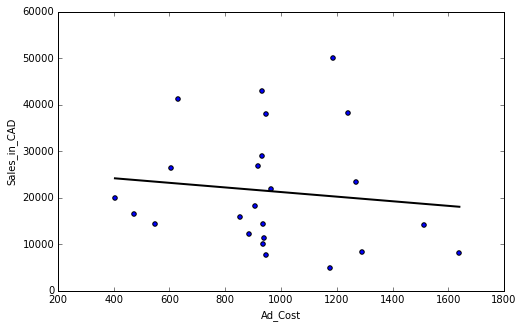

In [150]:
# Testing the plot function 
plot(Combineddata.Ad_Cost, Combineddata.Sales_in_CAD,'plot.pdf')